# Estimating Home Prices with Zillow

This notebook contains a detailed, step-by-step view of the data science pipeline in using Zillow data for estimate and predict values of homes. 

## Initialize Notebook

In [1]:
# import from standard libraries
import pandas as pd
import numpy as np

# import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns0

# import data manipulation tools
from sklearn.model_selection import train_test_split

# import module functions
from acquire import get_sql, acquire_mvp
from prepare import shed_zscore_outliers, show_distributions, prepare_mvp, split_data
from explore import get_tax_rate

# cosmetic settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')

## Acquire Data

In [2]:
# SQL query for initial DataFrame grab
# joins predictions_2017 for dates to filter "hot months"
# uses propertylandusetypeid as described in propertylandusetype
# table to filter only single unit properties
query = '''
SELECT *
FROM properties_2017
INNER JOIN predictions_2017 USING(parcelid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
WHERE
    propertylandusetypeid IN (261, 263, 264, 266, 268, 275, 276, 279) AND
    CAST(transactiondate AS DATE) BETWEEN 20170501 AND 20170831
ORDER BY
    properties_2017.id ASC
;'''

In [3]:
# obtain initial DataFrame using get_sql function
df = get_sql(query, 'zillow')

In [4]:
# check DataFrame dimensions
df.shape

(38412, 7)

In [5]:
# check first row of DataFrame
df.head(1).T

,0
property_id,349.00
bedrooms,4.00
bathrooms,5.00
fips,6111.00
square_feet,3760.00
tax_amount_usd,9673.46
tax_value_usd,872850.00


<br>🚨 **Notice** 🚨 <br>
_Multiple `id` columns exist, we will adjust our query to distinguish these and retain the `id` from the primary table._
<br><br>

In [6]:
# due to multiple id columns, set primary table key as "property_id"
query = '''
SELECT *, properties_2017.id AS property_id
FROM properties_2017
INNER JOIN predictions_2017 USING(parcelid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
WHERE
    propertylandusetypeid IN (261, 263, 264, 266, 268, 275, 276, 279) AND
    CAST(transactiondate AS DATE) BETWEEN 20170501 AND 20170831
ORDER BY
    properties_2017.id ASC
;'''

In [7]:
# obtain DataFrame with adjusted query
df = get_sql(query, 'zillow', use_csv=False)

In [8]:
# drop id columns while retainging property_id
df = df.drop(columns=['id'])

In [9]:
# set property_id as index to avoid losing this data in scaling
# due to human error
df = df.set_index('property_id')

In [10]:
# sort columns for ease of understanding
cols = list(df)
cols.sort()
df = df[cols]

In [11]:
# check DataFrame dimensions again
df.shape

(38412, 61)

In [12]:
# check first row of newly ordered DataFrame
df.head(1).T

property_id,349
airconditioningtypeid,NaN
architecturalstyletypeid,NaN
assessmentyear,2016.0
basementsqft,NaN
bathroomcnt,5.0
...,...
typeconstructiontypeid,NaN
unitcnt,NaN
yardbuildingsqft17,NaN
yardbuildingsqft26,NaN


In [13]:
# inspect DataFrame structure, values, counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38412 entries, 349 to 2982274
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         12222 non-null  float64
 1   architecturalstyletypeid      101 non-null    float64
 2   assessmentyear                38412 non-null  float64
 3   basementsqft                  25 non-null     float64
 4   bathroomcnt                   38412 non-null  float64
 5   bedroomcnt                    38412 non-null  float64
 6   buildingclasstypeid           0 non-null      object 
 7   buildingqualitytypeid         23698 non-null  float64
 8   calculatedbathnbr             38269 non-null  float64
 9   calculatedfinishedsquarefeet  38314 non-null  float64
 10  censustractandblock           38271 non-null  float64
 11  decktypeid                    321 non-null    float64
 12  finishedfloor1squarefeet      3153 non-null   float64
 1

<br>🚨 **Notice** 🚨 <br>
_Many columns have substantial amounts of data missing. We will drop columns with more than 5% null data._<br><br>

In [14]:
# drop columns with more than 5% data missing
df = df.dropna(axis=1, thresh=36491)

In [15]:
# recheck DataFrame .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38412 entries, 349 to 2982274
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   assessmentyear                38412 non-null  float64
 1   bathroomcnt                   38412 non-null  float64
 2   bedroomcnt                    38412 non-null  float64
 3   calculatedbathnbr             38269 non-null  float64
 4   calculatedfinishedsquarefeet  38314 non-null  float64
 5   censustractandblock           38271 non-null  float64
 6   finishedsquarefeet12          38200 non-null  float64
 7   fips                          38412 non-null  float64
 8   fullbathcnt                   38269 non-null  float64
 9   landtaxvaluedollarcnt         38411 non-null  float64
 10  latitude                      38412 non-null  float64
 11  logerror                      38412 non-null  float64
 12  longitude                     38412 non-null  float64
 1

### Initial Thoughts

Most of our initial columns were unusable due to significant missing data. Of the $38,412$ rows returned, some columns had null values for as much as $99\%$ of them. Our requisite variables for the minimally viable product, as well as our target, have sufficient usable data for our purposes. 

**Variables**:
- `calculatedfinishedsquarefeet`, 38314 _non-null_ values, dtype $=$ float64
- `bedroomcnt`, 38412 _non-null_ values, dtype $=$ float64
- `bathroomcnt`, 38412 _non-null_ values, dtype $=$  float64

**Target**:
- `taxvaluedollarcnt`, 38411 _non-null_ values, dtype $=$ float64

There is also sufficient data to obtain tax rates for counties in which the properties exist.

- `fips`, 38412 _non-null_ values, dtype $=$ float64
    - can be used with data from [census.gov](https://www.census.gov/prod/techdoc/cbp/95-96cd/fips-st.pdf) to establish county
- `taxamount`, 38411 _non-null_ values, dtype $=$ float64
    -  can be used in with `taxvaluedollarcnt` to obtain an estimated tax rate

**Takeaways**

Of our returned $38,412$ rows, the requisite variable that is missing the most data is `calculatedfinishedsquarefeet` with $98$ null values. This represents $\approx0.001\%$ of our data, and can be safely dropped without significant alarm. With enough time, we can explore additional variables for model creation. For now, we will move on with creating our minimally viable product.

**Starting Hypotheses**

- H$_0$: _Assessed property value does not increase with square feet of the structure._
- H$_a$: _Assessed property value increases with square feet of the structure._

It seems likely that as the dimensions of the property increase, that the value of the property would increase linearly with it.

In [16]:
df_mvp = acquire_mvp()

## Data Preparation
### Minimally Viable Product

In [17]:
# check DataFrame dimensions
df_mvp.shape

(38312, 6)

In [18]:
# inspect first row of DataFrame
df_mvp.head(1).T

property_id,349
bedrooms,4.00
bathrooms,5.00
fips,6111.00
square_feet,3760.00
tax_amount_usd,9673.46
tax_value_usd,872850.00


In [19]:
# view DataFrame structure, values, counts, and data types
df_mvp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38312 entries, 349 to 2982274
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        38312 non-null  float64
 1   bathrooms       38312 non-null  float64
 2   fips            38312 non-null  float64
 3   square_feet     38312 non-null  float64
 4   tax_amount_usd  38312 non-null  float64
 5   tax_value_usd   38312 non-null  float64
dtypes: float64(6)
memory usage: 2.0 MB


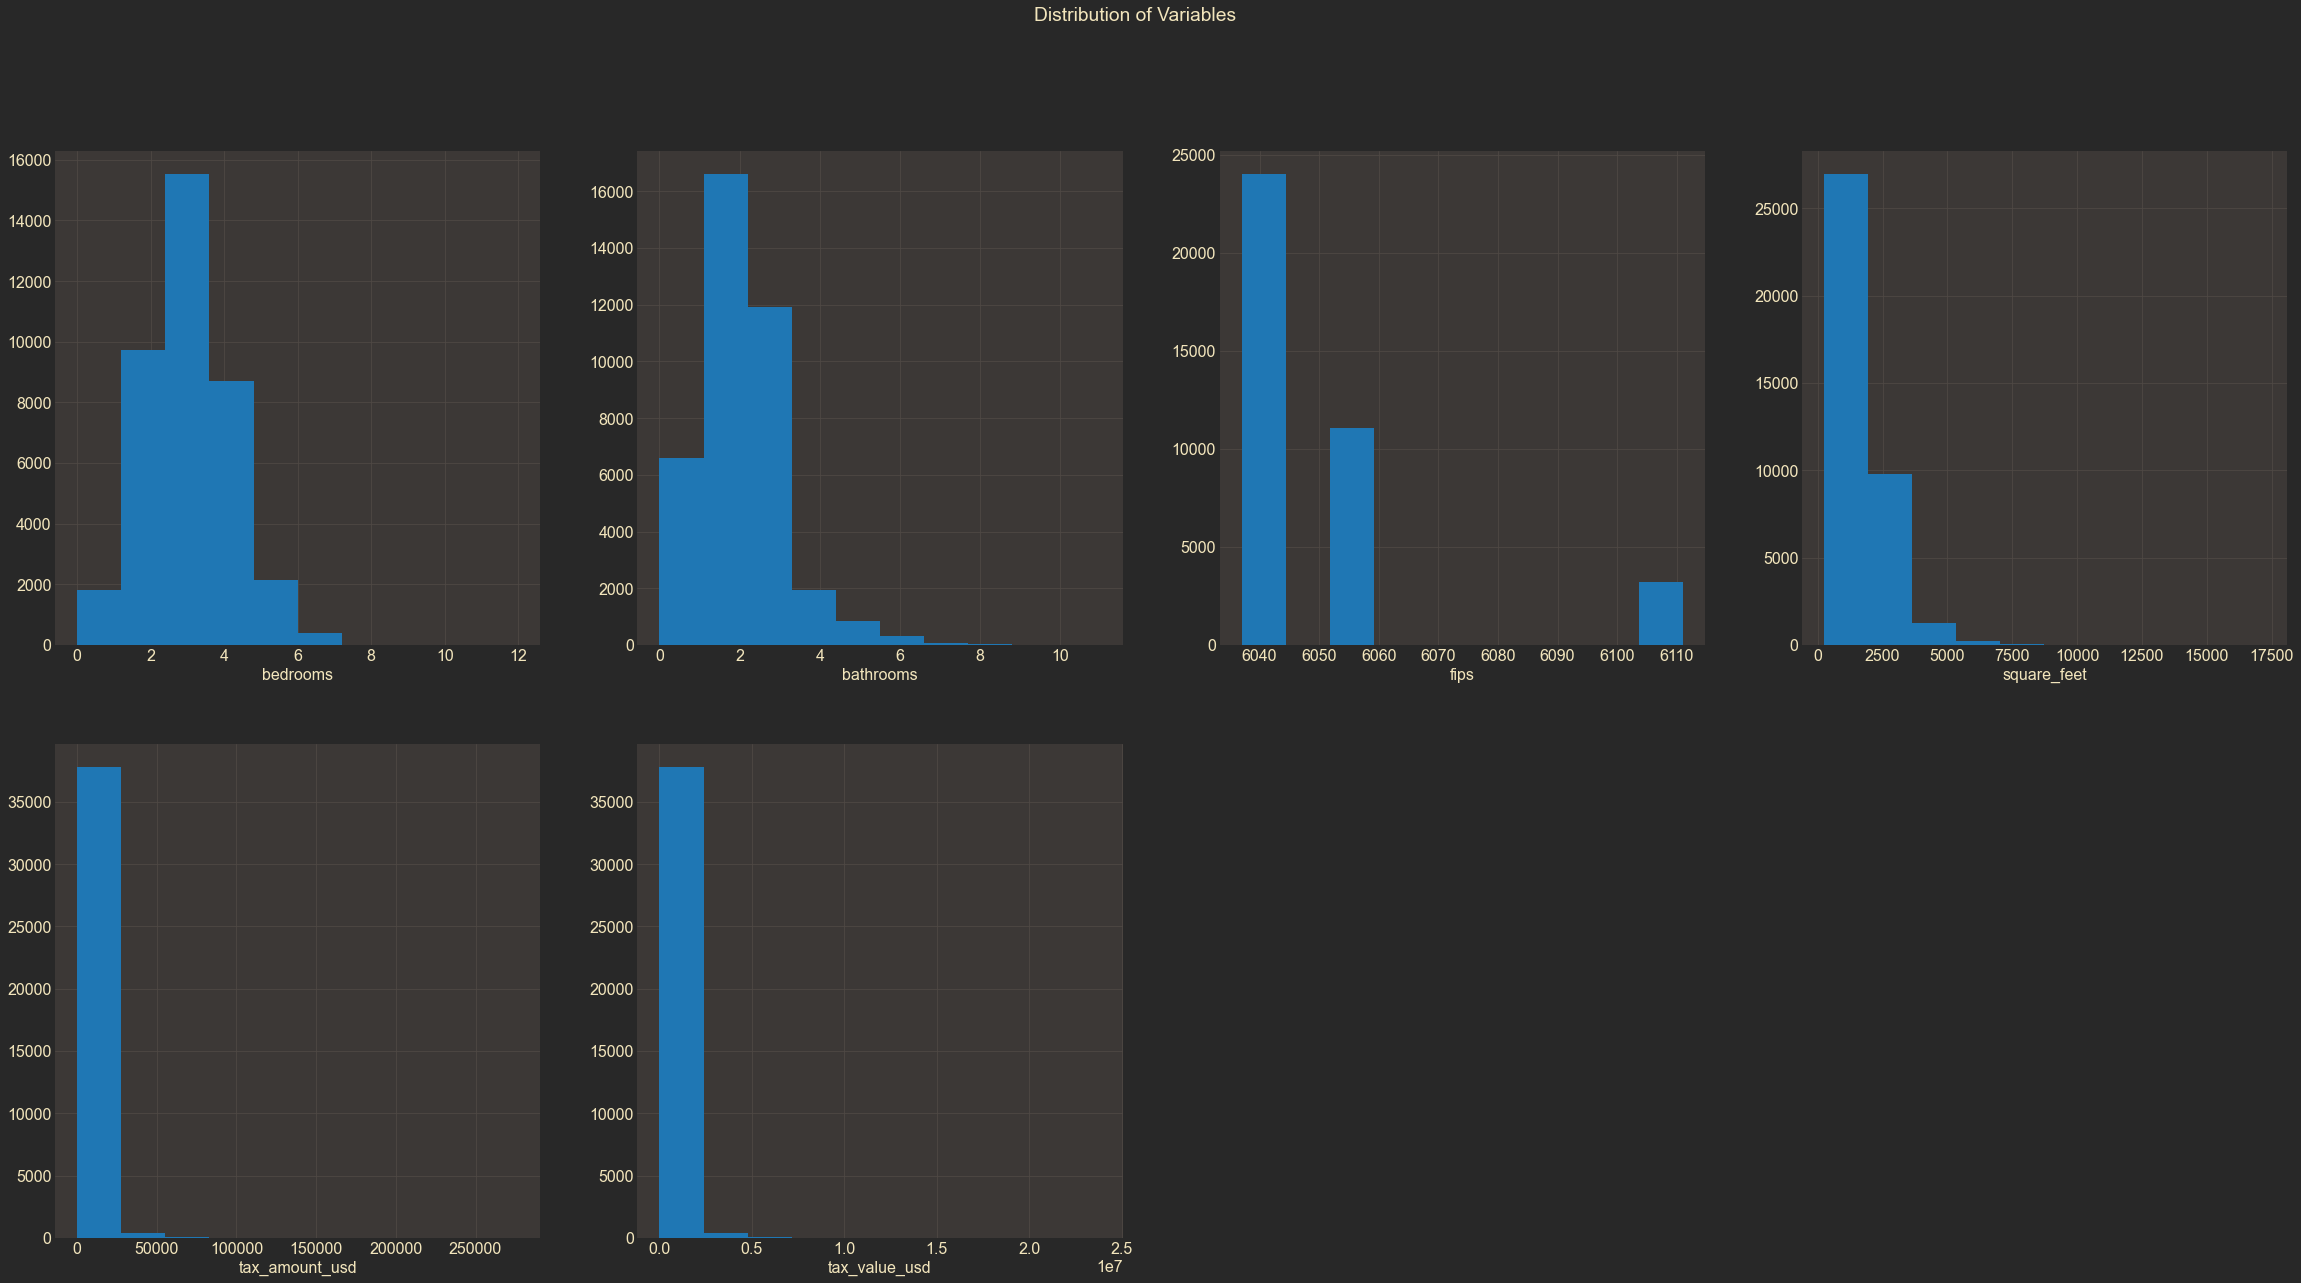

In [20]:
# visualize the MVP variables
show_distributions(df_mvp)

#### Data Impressions

Looking at the distributions, we can see some heavy right skews in `square_feet`, `tax_amount_usd`, `and tax_value_usd`. This can cause some problems down the line when scaling data for modeling, and it is best to remove some of the egregious outliers. We will create a function that can safely remove outliers, but allow us to exclude values that should not be pruned, like `fips`.

#### Handling Outliers
##### Using Z-Score

Here we have created a function that will remove all values that are $\pm$ 3 standard deviations from the mean. We will again visualize our variables to check the results.

In [21]:
# check dimensions before removing outliers
df_mvp.shape

(38312, 6)

In [22]:
# check dimensions for comparison after removal
df_mvp = shed_zscore_outliers(df_mvp, 'fips')

In [23]:
df_mvp.shape

(37249, 6)

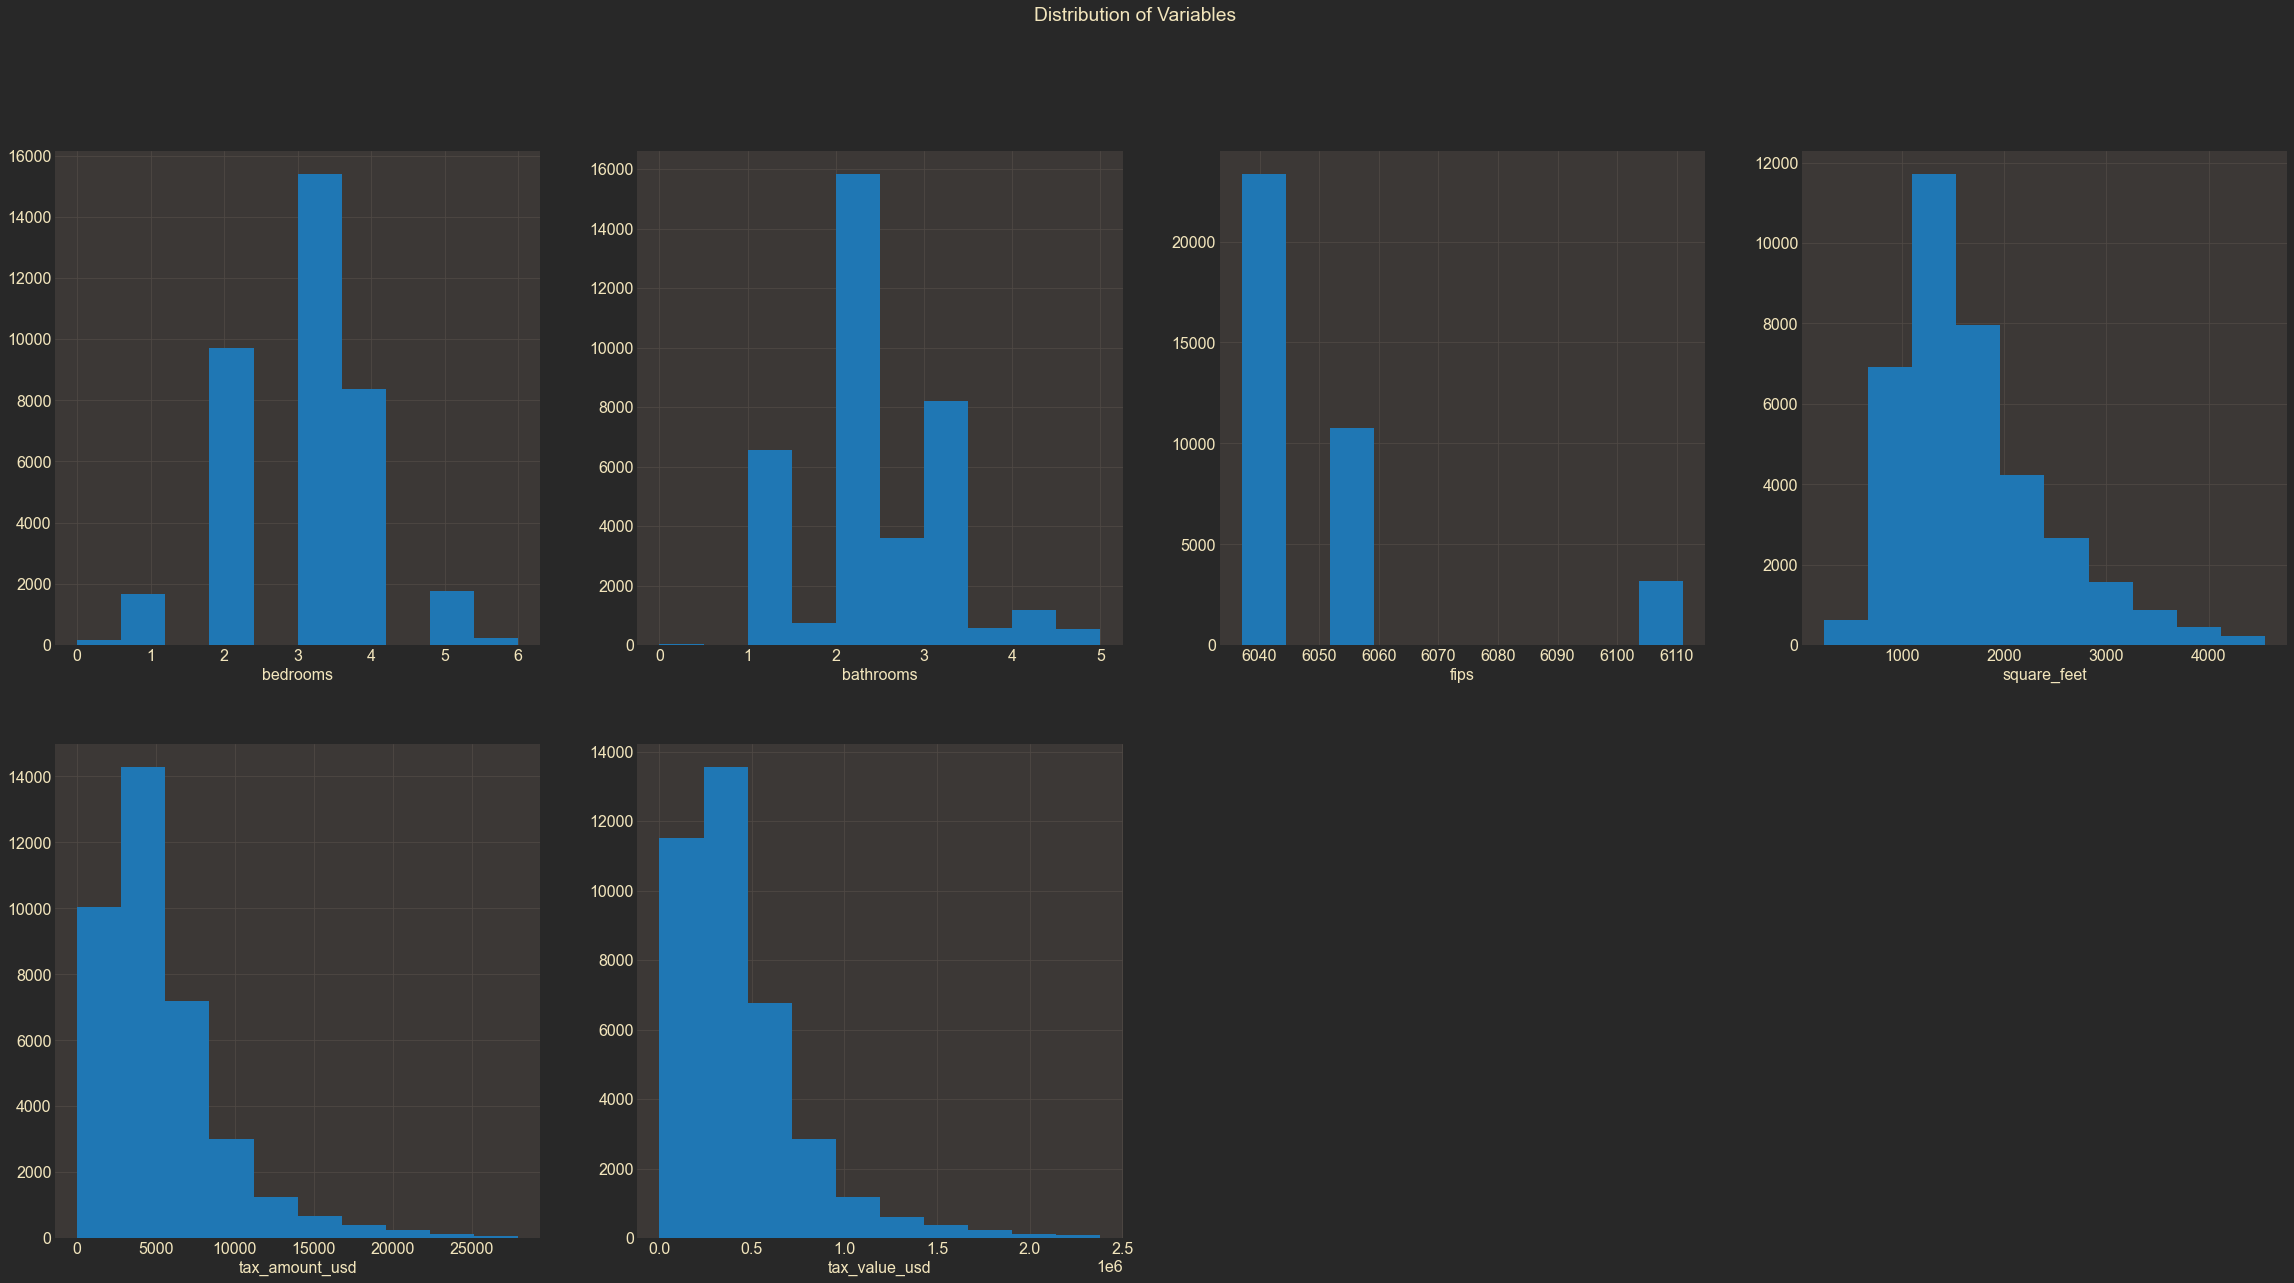

In [24]:
# visualize the new distributions
show_distributions(df_mvp)

<br>We can see there is still some right skew in the three variables mentioned before, but it has reduced quite significantly. This should improve the results of our scaled data being passed into our models later on. We see there are some properties that do not have a bathroom or a bedroom. This is unlikely to be the case for the single unit properties we are looking at, and is likely the result of missing data or improper labels. We will also drop these few rows to avoid using inappropriate data.<br><br>

In [25]:
# remove 0 values from bedrooms and bathrooms
df_mvp = df_mvp.loc[((df_mvp.bedrooms != 0) & (df_mvp.bathrooms != 0))]

In [26]:
# check shape to see remaining data
df_mvp.shape

(37091, 6)

In [27]:
# inspect values have been removed
df_mvp.bathrooms.unique()

array([5. , 2. , 1.5, 1. , 2.5, 3. , 4.5, 4. , 3.5])

In [28]:
# inspect values have been removed
df_mvp.bedrooms.unique()

array([4., 3., 2., 5., 1., 6.])

<br>Now that we have removed our inappropriate data, the last thing to do is replace our `fips`, or Federal Information Processing Standards codes, with human readable county names. These names are taken directly from the [cenusus.gov](https://www.census.gov/prod/techdoc/cbp/95-96cd/fips-st.pdf) website. All of the values within the `fips` column correspond to counties in the US state of California. We will use this data to calculate extimated tax rates for the counties in which these properties exist.<br><br>

In [29]:
# output fips values
df_mvp.fips.unique()

array([6111., 6037., 6059.])

In [30]:
# replace fips numerical codes with string county names and rename column
df_mvp.fips = np.where(df_mvp.fips == 6037.0, 'Los Angeles', df_mvp.fips)
df_mvp.fips = np.where(df_mvp.fips == '6059.0', 'Orange', df_mvp.fips)
df_mvp.fips = np.where(df_mvp.fips == '6111.0', 'Ventura', df_mvp.fips)
df_mvp = df_mvp.rename(columns=({'fips':'county'}))

In [31]:
# inspect first row
df_mvp.head(1).T

property_id,349
bedrooms,4.0
bathrooms,5.0
county,Ventura
square_feet,3760.0
tax_amount_usd,9673.46
tax_value_usd,872850.0


In [32]:
# inspect values counts
df_mvp.county.unique()

array(['Ventura', 'Los Angeles', 'Orange'], dtype=object)

### Finalize Preparation

Now that we have filled these values with human readable values, we can also encode this data to better use in machine learning. These will not be used in our MVP, but can be utilized in further modeling.

In [33]:
# reassign DataFrame to hold new encoded colummns
df_mvp = pd.get_dummies(df_mvp, columns=['county'], drop_first=True)

In [34]:
# check shape for new row
df_mvp.shape

(37091, 7)

In [35]:
# inspect first row
df_mvp.head(1).T

property_id,349
bedrooms,4.00
bathrooms,5.00
square_feet,3760.00
tax_amount_usd,9673.46
tax_value_usd,872850.00
county_Orange,0.00
county_Ventura,1.00


Now that we have completed this portion of data preparation and obtaining the requested county tax rates, we can move on to exploring our data for our minimally viable product. First we will create a function to obtain all our data as needed for our MVP to split into `train`, `validate`, and `test` datasets.

## Data Exploration

### Minimally Viable Product

In [39]:
# test split_data function on prepare_mvp and return explore
# DataFrame and X, y for train, validate, and test
df_mvp, \
X_train_mvp, y_train_mvp, \
X_validate_mvp, y_validate_mvp, \
X_test_mvp, y_test_mvp = split_data(prepare_mvp(), 'tax_value_usd')

In [40]:
# check dimensions of explore and X DataFrames
df_mvp.shape, X_train.shape, X_validate.shape, X_test.shape

((22254, 6), (22254, 5), (7418, 5), (7419, 5))

## Estimating Tax Rates

Now that we have our data prepared for exploration, we can also estimate our tax rates as requested for our deliverables. This data will not be used in modeling as it will be constructed using our target variable. We will use the function `get_tax_rate` from `prepare.py`.

In [38]:
get_tax_rate()

,avg_tax_amount_usd,avg_tax_value_usd,tax_rate
county_name,,,
Los Angeles,5159.400696,406432.952365,0.013783
Orange,5631.816593,483927.326698,0.012051
Ventura,5117.075751,437588.390903,0.011954


**Estimated Tax Rates**<br>

Using our available data, we can calculate an average tax rate for counties using `tax_amount_usd` and `tax_value_usd`.

- LA County: $\approx1.38\%$ of assessed property value
- Orange County: $\approx1.21\%$ of assessed property value
- Ventura County: $\approx1.2\%$ of assessed property value